admit    0
gre      0
gpa      0
rank     0
dtype: int64
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 400 entries, 0 to 399
Data columns (total 4 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   admit   400 non-null    int64  
 1   gre     400 non-null    int64  
 2   gpa     400 non-null    float64
 3   rank    400 non-null    int64  
dtypes: float64(1), int64(3)
memory usage: 12.6 KB


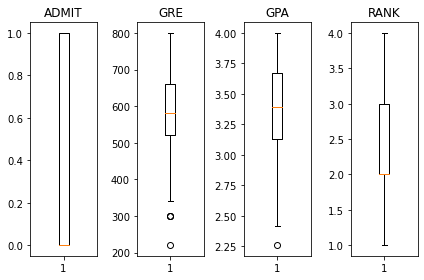

,admit,gre,gpa,rank
0,0,380,3.61,3
1,1,660,3.67,3
2,1,800,4.00,1
3,1,640,3.19,4
4,0,520,2.93,4


[[0.04545455 0.71111111 0.66666667]
 [0.68181818 0.75555556 0.66666667]
 [1.         1.         0.        ]
 ...
 [0.45454545 0.28888889 0.66666667]
 [0.77272727 0.74074074 0.33333333]
 [0.54545455 0.91851852 0.66666667]]
sklearn의 결과 : 합격여부 : [1], 확률 : [[0.43740782 0.56259218]]

Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where



loss의 값 : 0.6340963840484619
loss의 값 : 0.5909895300865173
loss의 값 : 0.5870102047920227
loss의 값 : 0.5862286686897278
loss의 값 : 0.5857675075531006
loss의 값 : 0.5853684544563293
loss의 값 : 0.5849980711936951
loss의 값 : 0.5846544504165649
loss의 값 : 0.5843310356140137
loss의 값 : 0.5840297341346741


In [1]:
import numpy as np
import pandas as pd
import tensorflow as tf
from sklearn import linear_model  # sklearn으로 logistic 구현
from sklearn.preprocessing import MinMaxScaler  # 정규화 진행
from scipy import stats   # 이상치 처리
import matplotlib.pyplot as plt
import warnings


# 경고메시지 출력하지 않아요!
warnings.filterwarnings(action='ignore')

# Raw Data Loading
df = pd.read_csv('./data/admission.csv')

#############################
# preprocessing
#############################

# 결측치부터 살펴보아야 해요!
print(df.isnull().sum())   # 결치값은 없네요!!
df.info()

# 이상치가 있는지를 확인하고 처리해 보아요!
# 종속변수의 이상치를 outlier
# 독립변수의 이상치를 지대값
# 이상치가 존재하는지를 눈으로 확인하는 가장 쉬운 방법은 boxplot
figure = plt.figure()
ax1 = figure.add_subplot(1,4,1)
ax2 = figure.add_subplot(1,4,2)
ax3 = figure.add_subplot(1,4,3)
ax4 = figure.add_subplot(1,4,4)
ax1.set_title('ADMIT')
ax2.set_title('GRE')
ax3.set_title('GPA')
ax4.set_title('RANK')

ax1.boxplot(df['admit'])
ax2.boxplot(df['gre'])
ax3.boxplot(df['gpa'])
ax4.boxplot(df['rank'])

figure.tight_layout()
plt.show()
# boxplot을 이용해서 눈으로 확인보니 이상치가 존재하네요!!
# z-score를 이용해서 이상치를 제거하고 진행해 보아요!
zscore_threshold = 2.0

for col in df.columns:
    outlier = df[col][np.abs(stats.zscore(df[col])) > zscore_threshold]
    df = df.loc[~df[col].isin(outlier)]
    
# 이상치를 제거했으니 정규화를 진행
display(df.head())
x_data = df.drop('admit', axis=1, inplace=False)
t_data = df['admit'].values.reshape(-1,1)  
# t_data는 0과 1로만 구성되어 있어요. 따라서 정규화를 할 필요가 없어요!

# 정규화를 하기 위해 scaler
scaler = MinMaxScaler()
scaler.fit(x_data)

norm_x_data = scaler.transform(x_data)
print(norm_x_data)

# training data set
# norm_x_data
# t_data

### sklearn 구현

model = linear_model.LogisticRegression()

model.fit(x_data, t_data)

my_score = np.array([[600, 3.8, 1]])
predict_val = model.predict(my_score)    # 0 or 1로 결과 도출
predict_proba = model.predict_proba(my_score) # 확률값으로 결과를 도출

print('sklearn의 결과 : 합격여부 : {}, 확률 : {}'.format(predict_val, 
                                                         predict_proba))

##############################
# tensorflow 구현

# training data set
# norm_x_data
# t_data

# placeholder
X = tf.placeholder(shape=[None,3], dtype=tf.float32)
T = tf.placeholder(shape=[None,1], dtype=tf.float32)

# Weight & bias
W = tf.Variable(tf.random.normal([3,1]))
b = tf.Variable(tf.random.normal([1]))

# Hypothesis, model, predict model, logistic regression model
logit = tf.matmul(X,W) + b
H = tf.sigmoid(logit)

# loss function, cross entropy, log loss라고 하기도 해요!
loss = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=logit,
                                                              labels=T))

# train
train = tf.train.GradientDescentOptimizer(learning_rate=1e-4).minimize(loss)

# Session, 초기화
sess = tf.Session()
sess.run(tf.global_variables_initializer())

# 반복학습

for step in range(300000):
    _, loss_val = sess.run([train, loss], 
                           feed_dict={X: norm_x_data,
                                      T: t_data})
    
    if step % 30000 == 0:
        print('loss의 값 : {}'.format(loss_val))
        

In [2]:
# predict
my_score = np.array([[600, 3.8, 1]])
norm_my_score = scaler.transform(my_score)

result = sess.run(H, feed_dict={X: norm_my_score})
print('tensorflow로 예측한 결과 : {}'.format(result)) 
# tensorflow로 예측한 결과는 탈락!

tensorflow로 예측한 결과 : [[0.57198584]]


In [9]:
### Regression의 Metircs를 알아보아요!

### 예제는 Ozone을 이용해서 Model을 만들어 보아요!
### model은 sklearn으로 구현해보아요!

import numpy as np
import pandas as pd
from sklearn import linear_model
from scipy import stats
from sklearn.model_selection import train_test_split


### Raw Data Loading
df = pd.read_csv('./data/ozone.csv')
# print(df.shape)   # (153, 6)

# 결측치부터 제거
training_data = df.dropna(how='any', inplace=False)
# print(training_data.shape)   # (111, 6)

# 이상치도 제거
zscore_threshold = 2.0

for col in training_data.columns:
    outlier = training_data[col][np.abs(stats.zscore(training_data[col])) > zscore_threshold]
    training_data = training_data.loc[~training_data[col].isin(outlier)]
    
# sklearn으로 구현할거라서 정규화처리는 하지 않을께요!
# display(training_data.head())

# Data Set
x_data = training_data[['Solar.R', 'Wind', 'Temp']].values
t_data = training_data['Ozone'].values.reshape(-1,1)

# Train / Validation Data Set
train_x_data, valid_x_data, train_t_data, valid_t_data = \
train_test_split(x_data,
                 t_data,
                 test_size=0.3,
                 random_state=2)   # random의 seed 역할

# Model
model = linear_model.LinearRegression()

# Model 학습
model.fit(train_x_data, train_t_data)

# 예측값(predict_value)
# 정답(valid_t_data)
predict_value = model.predict(valid_x_data)

# 예측값과 정답간의 차이가 작으면 작을수록 좋은거예요!

In [10]:
from sklearn.metrics import mean_absolute_error

print(mean_absolute_error(valid_t_data, predict_value))  #13.924465776324636

13.924465776324636


In [11]:
from sklearn.metrics import mean_squared_error

# 단위가 달라서 직관적이지 않음
print(mean_squared_error(valid_t_data, predict_value))

271.56711923670605


In [12]:
from sklearn.metrics import r2_score

print(r2_score(valid_t_data, predict_value))  # 0.3734728354920863
# 1과 가까울수록 좋은 모델

0.3734728354920863
